# Genearte, Plug-in, and Validate Carbon Yield Cuvres in a Single-stand Test Model

## Set up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and Run `ForestModel` instance

In [3]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
import numpy as np

In [5]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [6]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_test',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [7]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

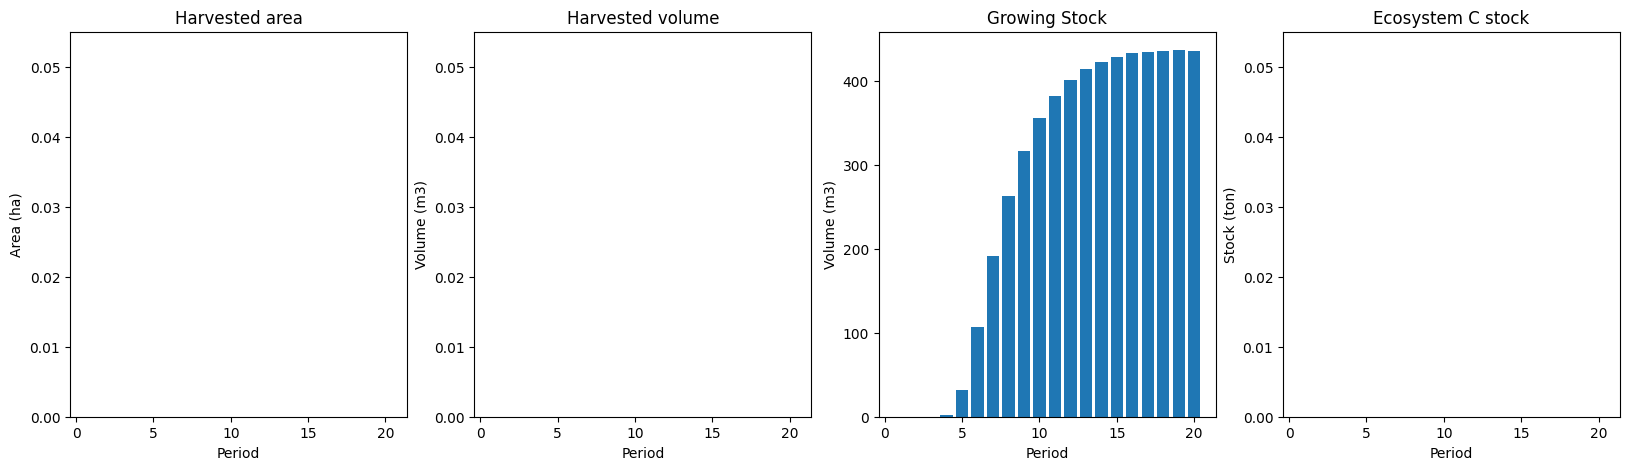

In [8]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [9]:
# Import Modules
import libcbm

Prepare CBM input files

In [10]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [11]:
# Define Sit_config File
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [12]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

In [13]:
from util import run_cbm

In [14]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length
# n_steps=700

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [82]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [16]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [17]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [18]:
def cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, production, n_steps):
    
    # Add carbon pools indicators 
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_carbon_stock = pd.DataFrame({'Year': pi['timestep'],
                                        'Biomass': pi[biomass_pools].sum(axis=1),
                                        'DOM': pi[dom_pools].sum(axis=1),
                                        'Ecosystem': pi[biomass_pools + dom_pools].sum(axis=1)})

    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_all_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'All_Emissions': fi[total_emission].sum(axis=1)})

    # Calculating gross growth fluxes
    annual_gross_growth = pd.DataFrame({'Year': fi['timestep'],
                                        'Gross_Growth': fi[gross_growth].sum(axis=1)})
    
    # Calculating HWPs carbon
    annual_harvested_carbon = pd.DataFrame({'Year': fi['timestep'],
                                            'Harvested_Carbon': fi[production].sum(axis=1)})


    # Calculating net emissions (All_Emissions - Gross_Growth)
    annual_net_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'Net_Emissions': annual_all_emission['All_Emissions'] - annual_gross_growth['Gross_Growth']})

    df_cs = annual_carbon_stock.groupby('Year').sum()
    df_ae = annual_all_emission.groupby('Year').sum()
    df_gg = annual_gross_growth.groupby('Year').sum()  # Updated to Gross Growth
    df_ne = annual_net_emission.groupby('Year').sum()
    df_hc = annual_harvested_carbon.groupby('Year').sum()

    # Merging all dataframes, now including net emissions and gross growth
    merged_df = pd.merge(pd.merge(pd.merge(pd.merge(df_cs, df_ae, left_index=True, right_index=True, how='outer'),
                                           df_gg, left_index=True, right_index=True, how='outer'),
                                  df_ne, left_index=True, right_index=True, how='outer'),
                         df_hc, left_index=True, right_index=True, how='outer')

    # Calculating stock change
    merged_df['Stock_Change'] = merged_df['Ecosystem'].diff() * (-1)
    merged_df.at[0, 'Stock_Change'] = 0

    # Calculating (Stock Change - Harvested Carbon)
    merged_df['Stock_Change_minus_Harvested_Carbon'] = merged_df['Stock_Change'] - merged_df['Harvested_Carbon']

    # Plotting the graphs
    fig, axs = plt.subplots(8, 1, figsize=(10, 40))

    # Plot 1: Biomass Stock
    axs[0].plot(merged_df.index, merged_df['Biomass'], label='Biomass Stock', color='green')
    axs[0].set_title("Annual Biomass Stock")
    axs[0].set_xlabel("Year")
    axs[0].set_ylabel("Stock (ton C)")
    axs[0].set_xlim(0, n_steps)

    # Plot 2: DOM Stock
    axs[1].plot(merged_df.index, merged_df['DOM'], label='DOM Stock', color='brown')
    axs[1].set_title("Annual DOM Stock")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Stock (ton C)")
    axs[1].set_xlim(0, n_steps)

    # Plot 3: Ecosystem Stock
    axs[2].plot(merged_df.index, merged_df['Ecosystem'], label='Ecosystem Stock', color='blue')
    axs[2].set_title("Annual Ecosystem Stock")
    axs[2].set_xlabel("Year")
    axs[2].set_ylabel("Stock (ton C)")
    axs[2].set_xlim(0, n_steps)

    # Plot 4: All Emissions
    axs[3].plot(merged_df.index, merged_df['All_Emissions'], label='All Emissions', color='red')
    axs[3].set_title("Annual Total Ecosystem Carbon Emissions")
    axs[3].set_xlabel("Year")
    axs[3].set_ylabel("Emissions (ton C)")
    axs[3].set_xlim(0, n_steps)

    # Plot 5: Gross Growth
    axs[4].plot(merged_df.index, merged_df['Gross_Growth'], label='Gross Growth', color='purple')
    axs[4].set_title("Annual Gross Growth")
    axs[4].set_xlabel("Year")
    axs[4].set_ylabel("Growth (ton C)")
    axs[4].set_xlim(0, n_steps)

    # Plot 6: Net Emissions
    axs[5].plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange')
    axs[5].set_title("Annual Net Ecosystem Carbon Emissions")
    axs[5].set_xlabel("Year")
    axs[5].set_ylabel("Emissions (ton C)")
    axs[5].set_xlim(0, n_steps)

    # Plot 7: Stock Change
    axs[6].plot(merged_df.index, merged_df['Stock_Change'], label='Stock Change', color='cyan')
    axs[6].set_title("Annual Ecosystem Carbon Stock Change")
    axs[6].set_xlabel("Year")
    axs[6].set_ylabel("Stock Change (ton C)")
    axs[6].set_xlim(0, n_steps)

    # Plot 8: Harvested Carbon
    axs[7].plot(merged_df.index, merged_df['Harvested_Carbon'], label='Harvested Carbon', color='magenta')
    axs[7].set_title("Annual Harvested Carbon")
    axs[7].set_xlabel("Year")
    axs[7].set_ylabel("Harvested Carbon (ton C)")
    axs[7].set_xlim(0, n_steps)

    # Comparison plot for Net Emissions vs (Stock Change - Harvested Carbon)
    plt.figure(figsize=(10, 6))
    plt.plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange', linestyle='--')
    plt.plot(merged_df.index, merged_df['Stock_Change_minus_Harvested_Carbon'], 
             label='Stock Change - Harvested Carbon', color='blue')
    plt.title("Comparison of Annual Net Emissions and Annual (Stock Change - Harvested Carbon)")
    plt.xlabel("Year")
    plt.ylabel("Carbon (ton C)")
    plt.legend()

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

    return merged_df

### No-harvesting

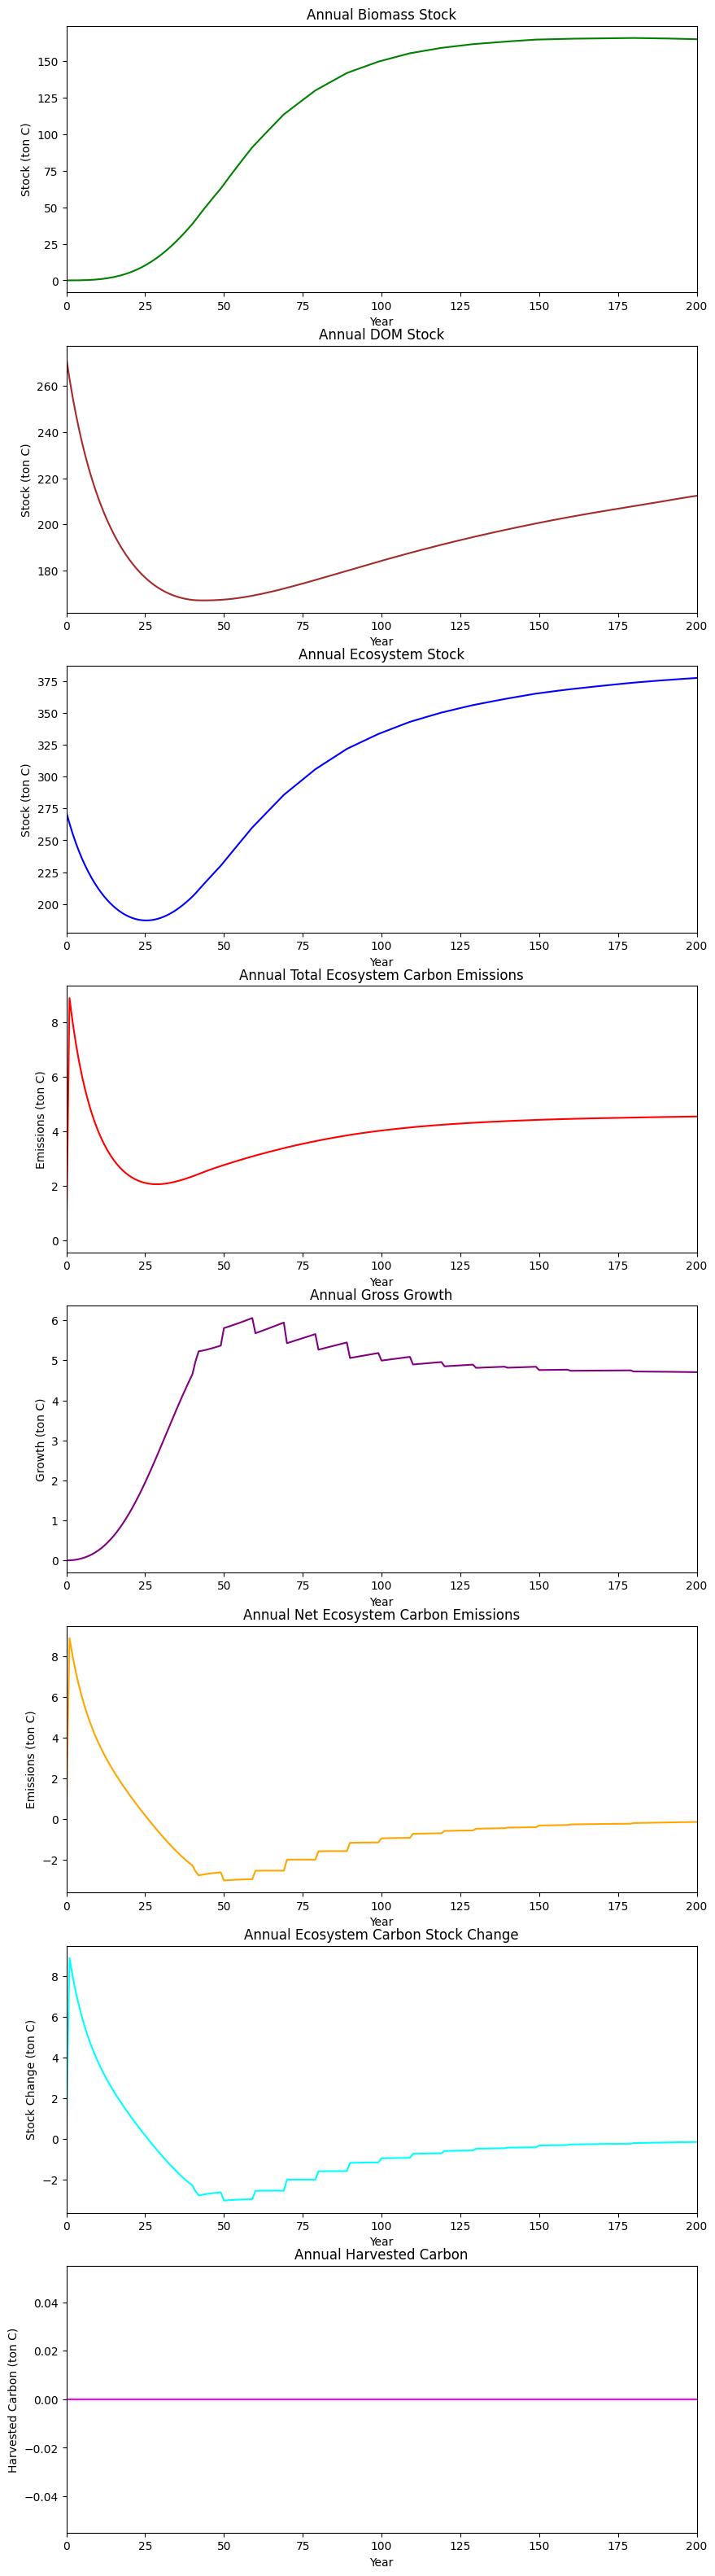

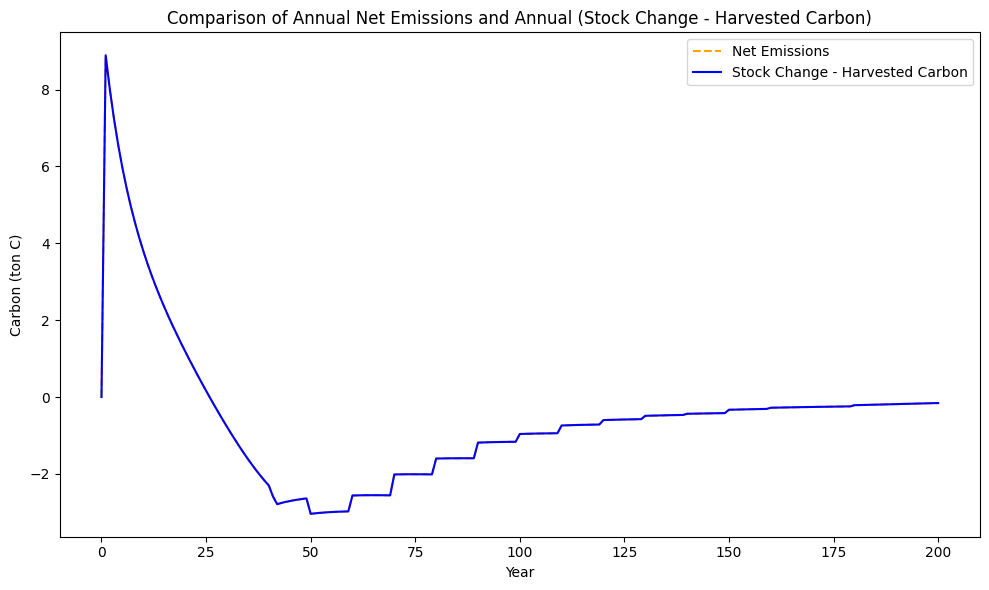

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Net_Emissions,Harvested_Carbon,Stock_Change,Stock_Change_minus_Harvested_Carbon
Year,,,,,,,,,
0,0.000327,272.192442,272.192769,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.002983,263.297469,263.300452,8.895193,0.002875,8.892317,0.0,8.892317,8.892317
2,0.010871,255.289686,255.300557,8.008698,0.008803,7.999895,0.0,7.999895,7.999895
3,0.027211,248.044540,248.071751,7.247650,0.018844,7.228806,0.0,7.228806,7.228806
4,0.055435,241.460237,241.515672,6.589714,0.033635,6.556079,0.0,6.556079,6.556079
...,...,...,...,...,...,...,...,...,...
196,165.123599,211.568004,376.691603,4.542324,4.709132,-0.166808,0.0,-0.166808,-0.166808
197,165.067176,211.788541,376.855718,4.543940,4.708054,-0.164115,0.0,-0.164115,-0.164115
198,165.010751,212.006469,377.017220,4.545474,4.706976,-0.161502,0.0,-0.161502,-0.161502


In [84]:
# Report Annual CBM Results
# from util import cbm_report
cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, n_steps)

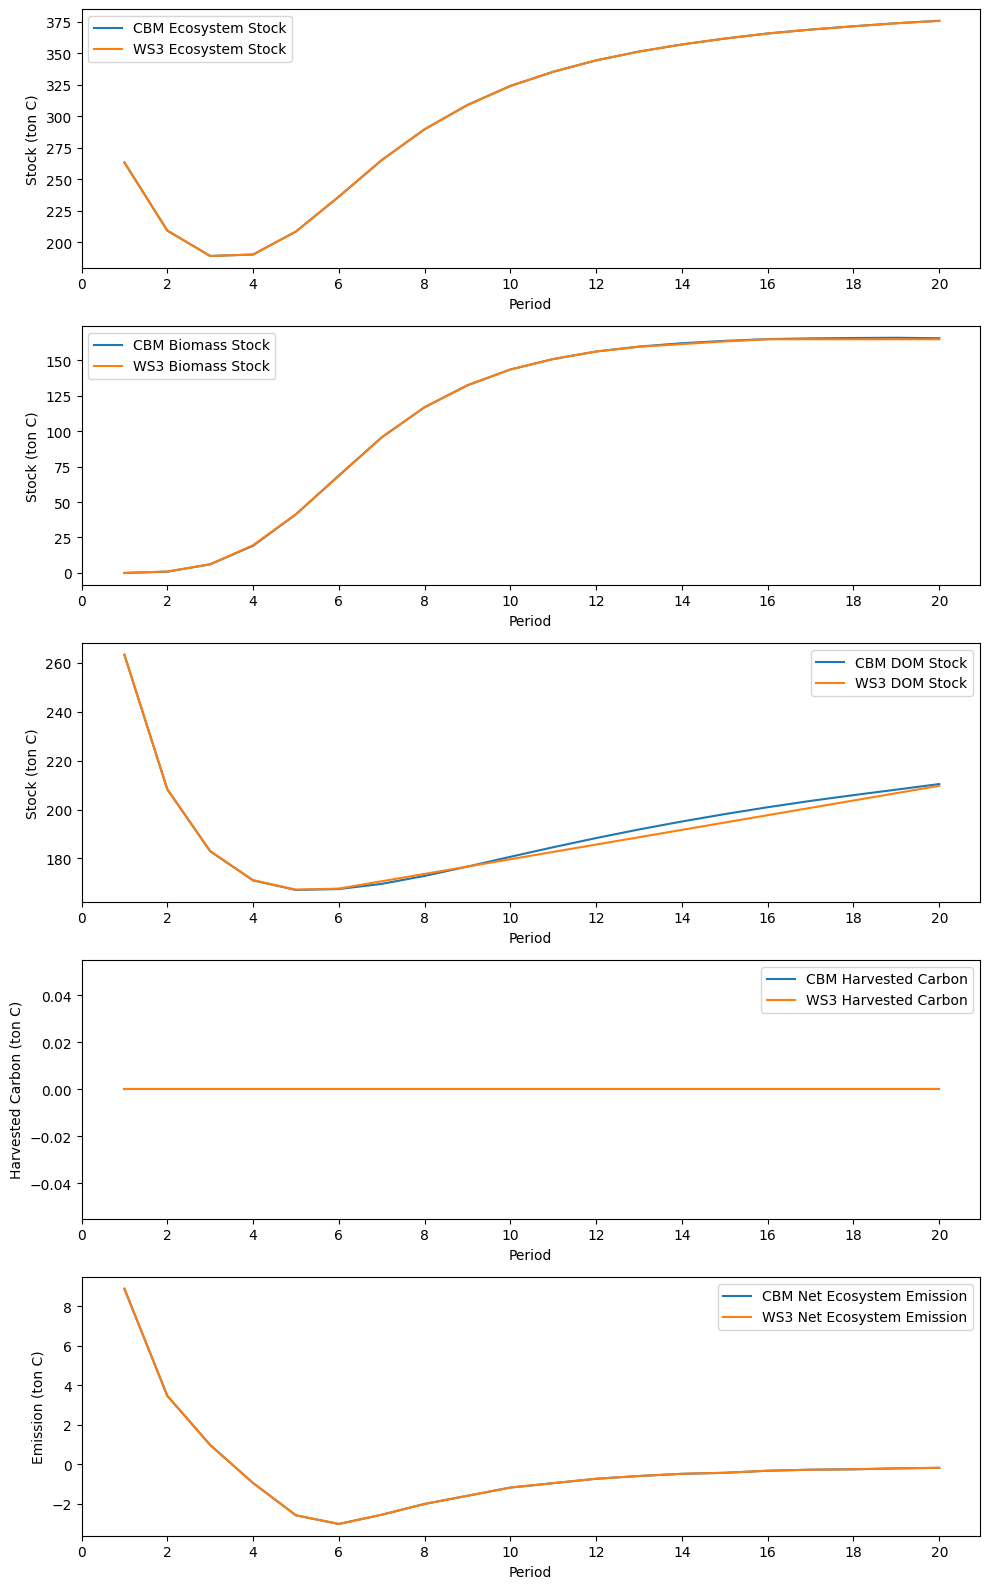

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5      41.345599  167.115383  208.460982        2.391898   
 5        6      68.654270  167.492616  236.146886        2.803922   
 6        7      95.596323  169.604358  265.200682        3.147085   
 7        8     116.807124  172.860296  289.667420        3.441617   
 8        9     132.272815  176.673403  308.946218        3.688798   
 9       10     143.383005  180.678345  324.061350        3.890504   
 10      11     150.744712  184.596533  335.341244        4.046081   
 11      12     156.055400  188.343102  344.398502        4.167048   
 12      13     159.522503  191.855391  351.377894        4.259287   
 13      14     161.

In [42]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

### Applied Four Clear-cuts

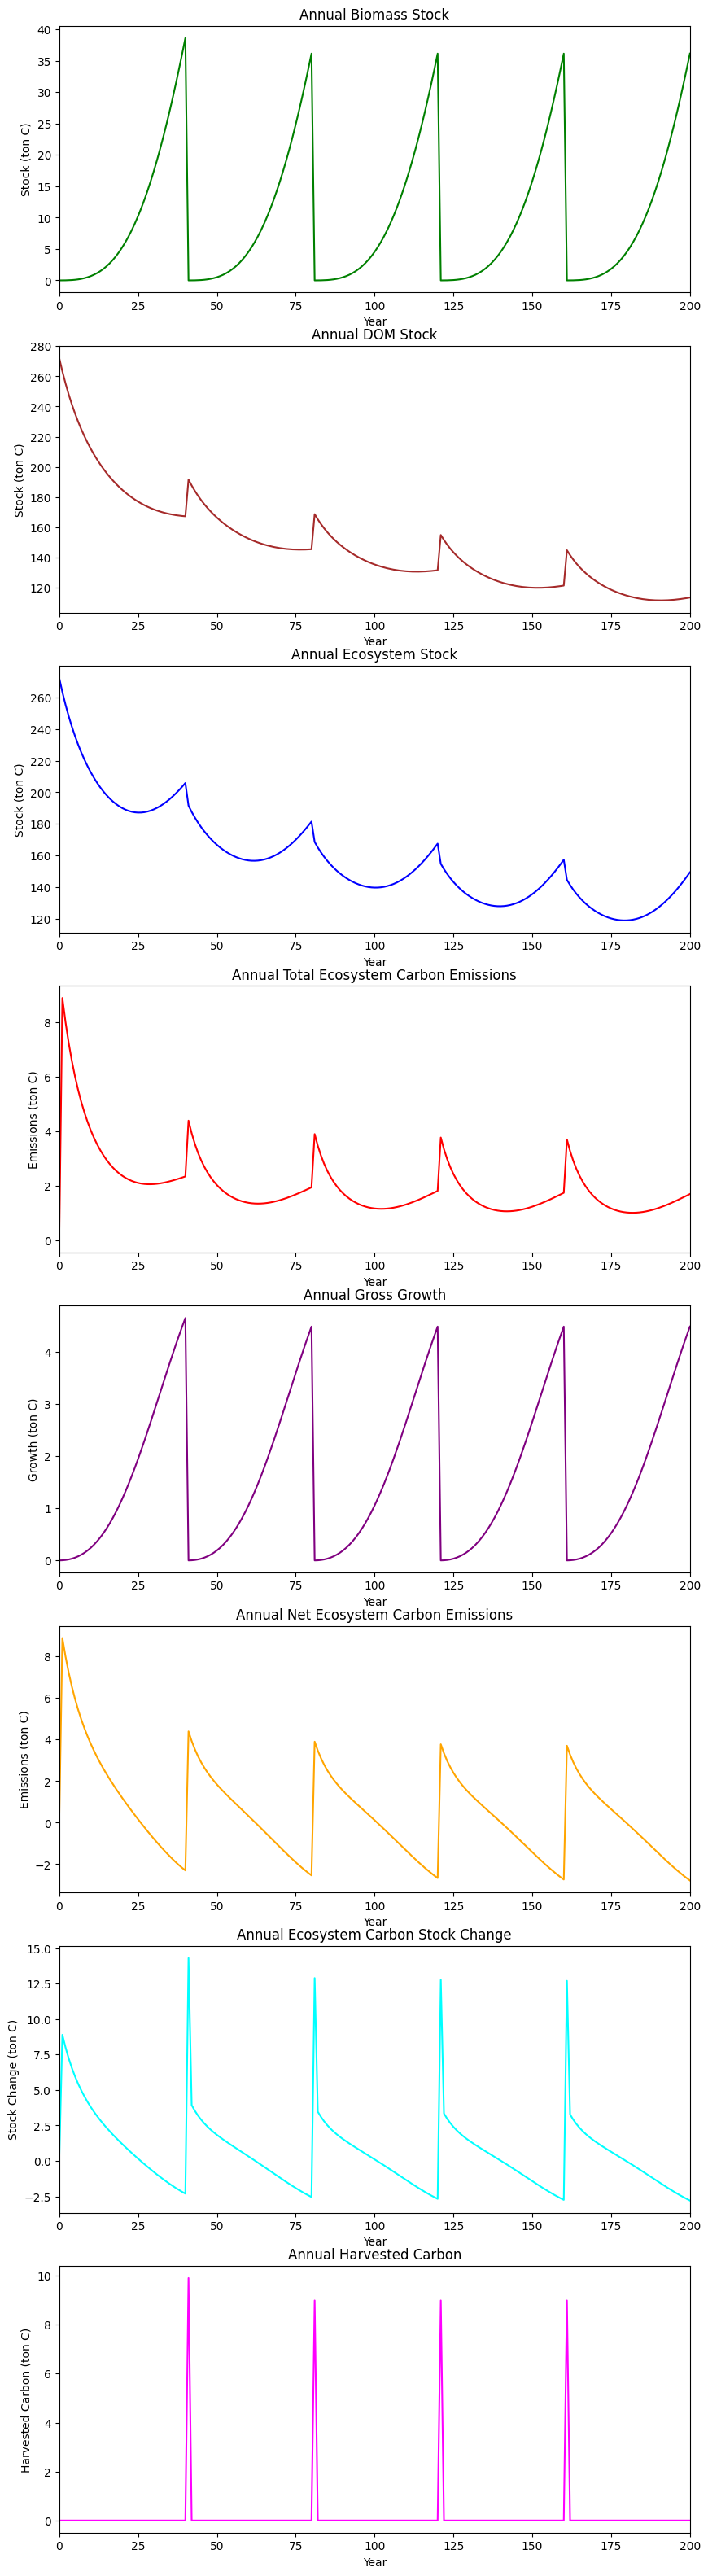

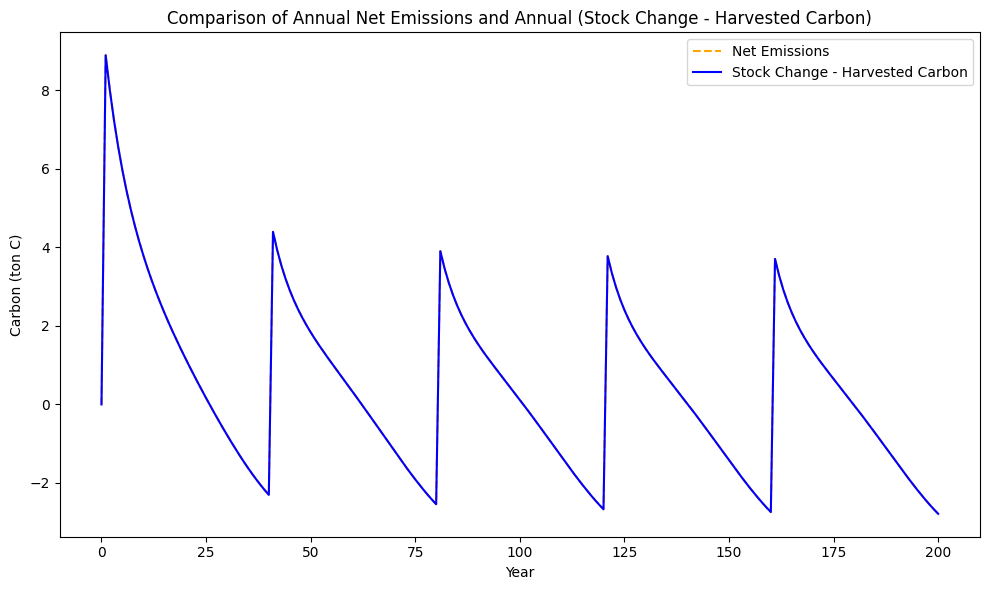

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Net_Emissions,Harvested_Carbon,Stock_Change,Stock_Change_minus_Harvested_Carbon
Year,,,,,,,,,
0,0.000327,272.192442,272.192769,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.002983,263.297469,263.300452,8.895193,0.002875,8.892317,0.0,8.892317,8.892317
2,0.010871,255.289686,255.300557,8.008698,0.008803,7.999895,0.0,7.999895,7.999895
3,0.027211,248.044540,248.071751,7.247650,0.018844,7.228806,0.0,7.228806,7.228806
4,0.055435,241.460237,241.515672,6.589714,0.033635,6.556079,0.0,6.556079,6.556079
...,...,...,...,...,...,...,...,...,...
196,26.958657,112.101262,139.059919,1.475804,3.780658,-2.304854,0.0,-2.304854,-2.304854
197,29.133534,112.358873,141.492407,1.530975,3.963463,-2.432488,0.0,-2.432488,-2.432488
198,31.392999,112.654696,144.047695,1.587385,4.142672,-2.555288,0.0,-2.555288,-2.555288


In [72]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output_harvest, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, n_steps)

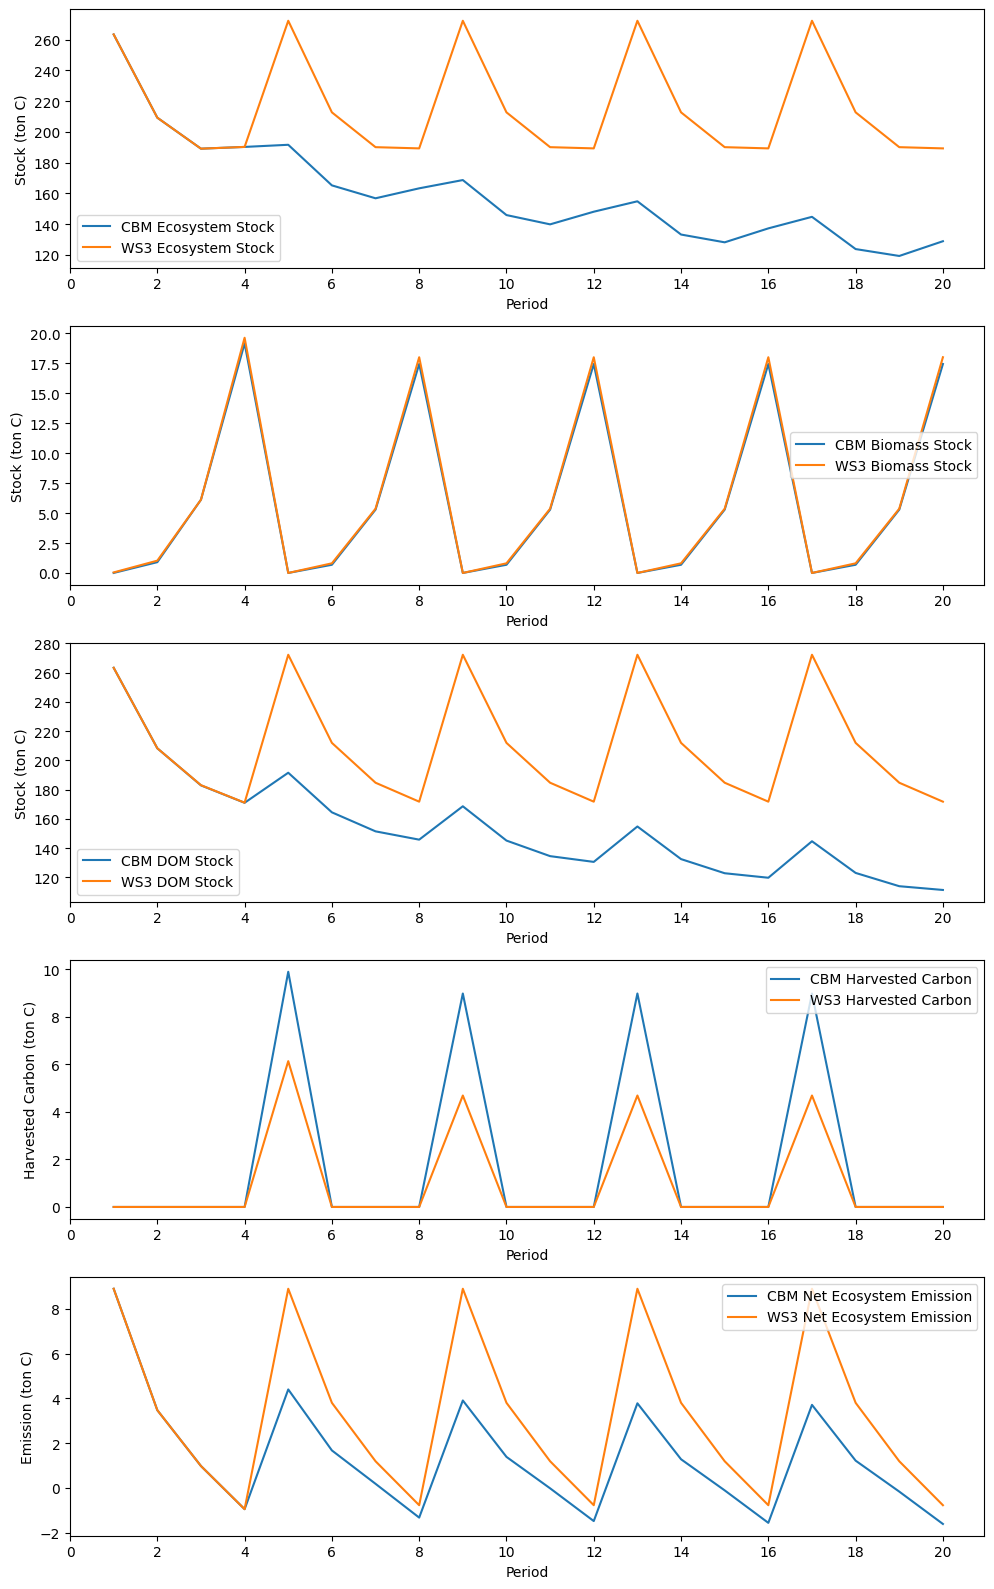

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5       0.000327  191.574854  191.575181        4.395538   
 5        6       0.683776  164.503884  165.187660        1.913622   
 6        7       5.284915  151.507205  156.792120        1.364508   
 7        8      17.434760  145.835426  163.270186        1.513885   
 8        9       0.000327  168.645898  168.646225        3.902991   
 9       10       0.683776  145.204622  145.888398        1.625478   
 10      11       5.284915  134.565345  139.850260        1.162601   
 11      12      17.434760  130.637355  148.072115        1.358328   
 12      13       0.000327  154.834772  154.835099        3.776325   
 13      14       0.

In [87]:
compare_ws3_cbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

## Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [20]:
sit_events = sit_tables['sit_events']

In [21]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [22]:
sit_inventory = sit_tables['sit_inventory']

In [23]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,1,2403002,204,2423002,softwood,FALSE,1,1.0,0,0,fire,harvest


In [24]:
# Set Age and Area to 0 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [25]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,1,2403002,204,2423002,softwood,FALSE,1,1.0,0,0,fire,harvest


Use the following code if any of the developments have no harvesting circumstances.

In [26]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [27]:
# Run CBM and Generate CBM 0utputs
cbm_output_curves = run_cbm(sit_config, sit_tables, n_steps=700)

In [28]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [29]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [30]:
# Generate Carbon Pool and Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [31]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [32]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 1 2403002 204 2423002 0              0.000002         0.000266   
                            1              0.000032         0.002409   
                            2              0.000180         0.008716   
                            3              0.000616         0.021651   
                            4              0.001597         0.043768   
...                                             ...              ...   
                            196           93.994458         8.686647   
                            197           93.955972         8.685097   
                            198           93.917484         8.683546   
                            199           93.878994         8.681994   
                            200           93.859749         8.681218   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 1 2403002 204 2423002 0              0.000000             0.000034   
                            1              0.000000             0.000311   
                            2              0.000000             0.001134   
                            3              0.000000             0.002839   
                            4              0.000000             0.005785   
...                                             ...                  ...   
                            196           32.444589            27.551492   
                            197           32.438453            27.541724   
                            198           32.432318            27.531955   
                            199           32.426182            27.522185   
                            200           32.423113            27.517300   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 1 2403002 204 2423002 0                  0.000025            0.0   
                            1                  0.000231            0.0   
                            2                  0.000841            0.0   
                            3                  0.002105            0.0   
                            4                  0.004286            0.0   
...                                                 ...            ...   
                            196                2.446413            0.0   
                            197                2.445930            0.0   
                            198                2.445448            0.0   
                            199                2.444967            0.0   
                            200                2.444726            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 1 2403002 204 2423002 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
                            196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 1 2403002 204 2423002 0                       

In [33]:
# c_curves_p.to_pickle("curves/c_curves_p_700_age1.pkl")

In [34]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 1 2403002 204 2423002 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
                            196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   

In [35]:
c_curves_f['total_emission'] = c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [36]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 1 2403002 204 2423002 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
                            196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   

In [37]:
# Update the values of timestep 0 to be equal to timestep 1
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [38]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 1 2403002 204 2423002 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
                            196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 1 2403002 204 2423002 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
                            196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 1 2403002 204 2423002 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
                            196                             0.0   

In [39]:
def plugin_c_curves(fm, c_curves_p, c_curves_f, pools, fluxes):
    # Dictionary to track registered curves for each dtype_key
    registered_curves = {}

    for dtype_key in fm.dtypes:
        dt = fm.dt(dtype_key)
        mask = ('?', '?', dtype_key[2], '?', dtype_key[4])
        
        for _mask, ytype, curves in fm.yields:
            if _mask != mask: 
                continue  # Only proceed if the mask matches

            print('found match for mask', mask)

            # Initialize the tracking of registered curves for the dtype_key if not already done
            if dtype_key not in registered_curves:
                registered_curves[dtype_key] = set()

            # Register pool curves
            pool_data = c_curves_p.loc[' '.join(dtype_key)]
            for yname in pools:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(pool_data.index.values, pool_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)

                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)

            # Register flux curves
            flux_data = c_curves_f.loc[' '.join(dtype_key)]
            for yname in fluxes:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(flux_data.index.values, flux_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)

                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)


In [40]:
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

found match for mask ('?', '?', '2403002', '?', '2423002')


In [40]:
# Check if all carbon yield curves are plugged in well.
# fm.yields

### Schedule Harvests

In [43]:
# sch =[(('tsa24', '1', '2403002', '204', '2423002'), 91, 1.0, 'harvest', 10, '_existing')]

In [55]:
# sch =[(('tsa24', '1', '2403002', '204', '2423002'), 71, 1.0, 'harvest', 8, '_existing'),
#       (('tsa24', '1', '2403002', '204', '2423002'), 70, 1.0, 'harvest', 15, '_existing')]

In [69]:
sch =[(('tsa24', '1', '2403002', '204', '2423002'), 51, 1.0, 'harvest', 6, '_existing'),
      (('tsa24', '1', '2403002', '204', '2423002'), 50, 1.0, 'harvest', 11, '_existing'),
      (('tsa24', '1', '2403002', '204', '2423002'), 50, 1.0, 'harvest', 16, '_existing')]

In [70]:
# sch =[(('tsa24', '1', '2403002', '204', '2423002'), 41, 1.0, 'harvest', 5, '_existing'),
#       (('tsa24', '1', '2403002', '204', '2423002'), 40, 1.0, 'harvest', 9, '_existing'),
#       (('tsa24', '1', '2403002', '204', '2423002'), 40, 1.0, 'harvest', 13, '_existing'),
#       (('tsa24', '1', '2403002', '204', '2423002'), 40, 1.0, 'harvest', 17, '_existing')]

In [71]:
fm.apply_schedule(sch, 
                  force_integral_area=False, 
                  override_operability=False,
                  fuzzy_age=False,
                  recourse_enabled=False,
                  verbose=False,
                  compile_c_ycomps=True)

0.0

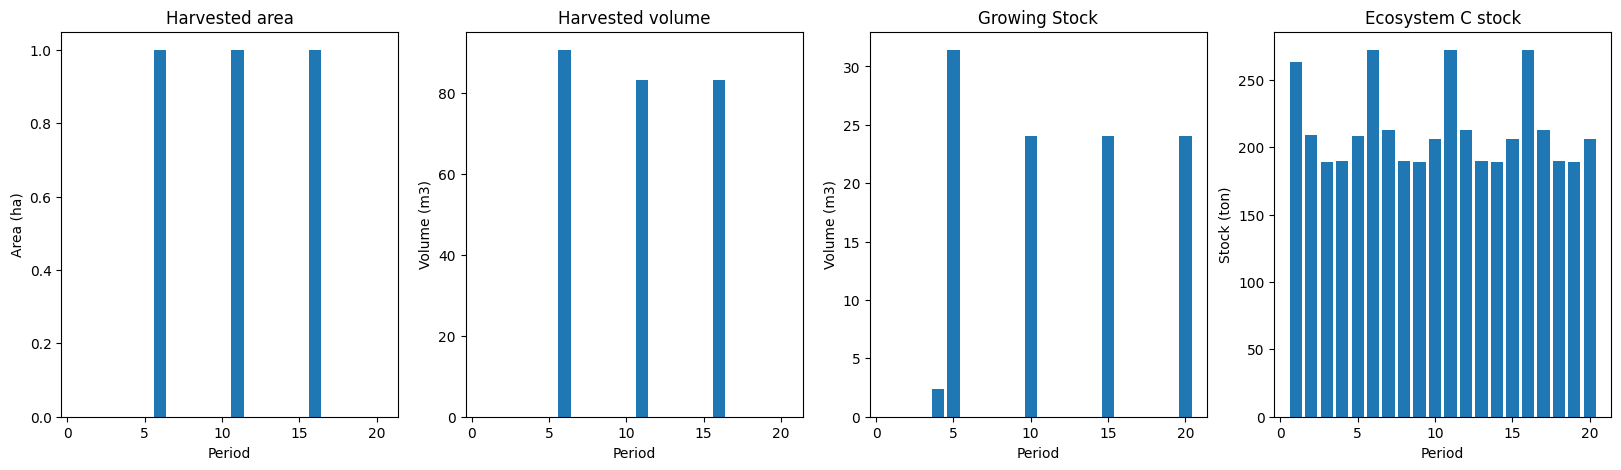

In [72]:
df_harvest = compile_scenario(fm)
fig, ax = plot_scenario(df_harvest)

In [73]:
#Import Module
from util import compile_events

In [74]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [75]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [76]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [77]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,51
1,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,101
2,tsa24,1,2403002,204,2423002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1.0,harvest,151


In [78]:
# Run CBM and Generate CBM Ouputs
cbm_output_harvest = run_cbm(sit_config, sit_tables, n_steps)

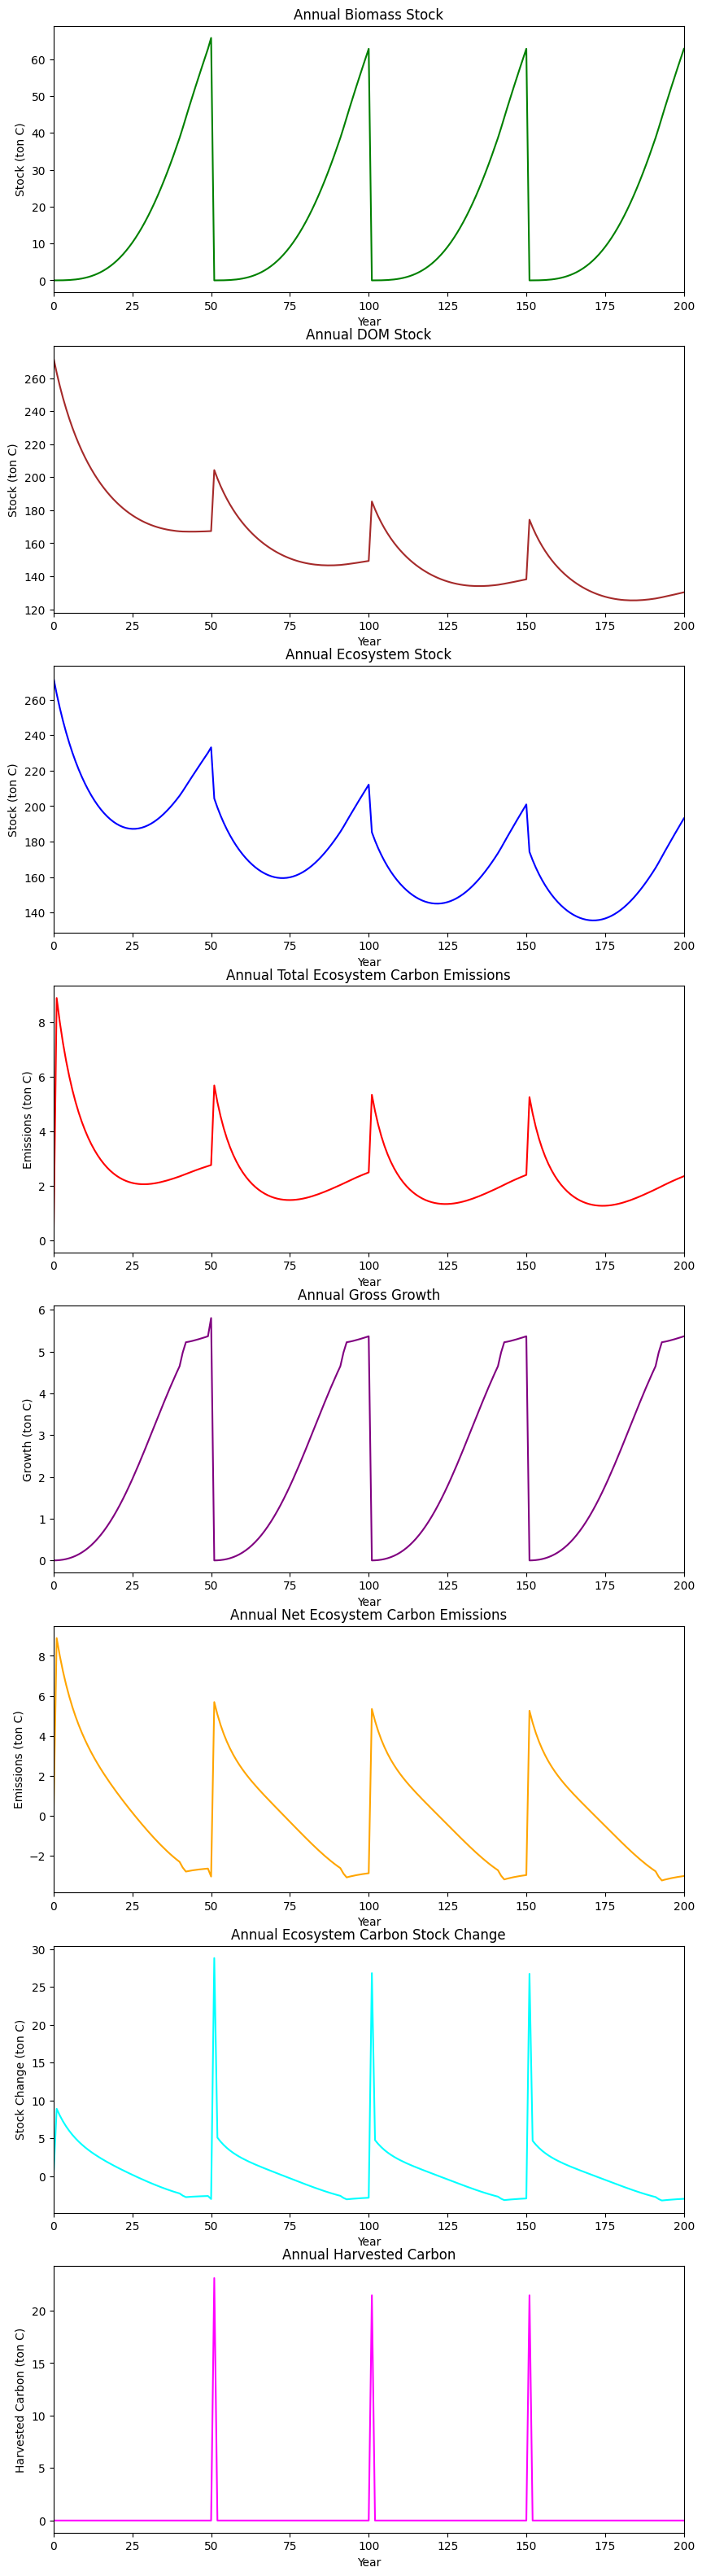

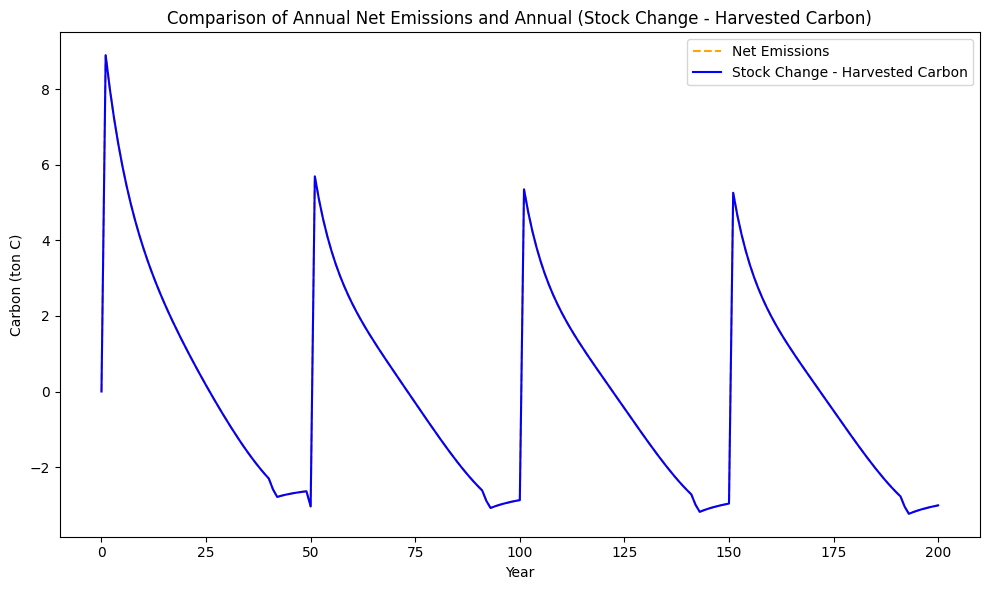

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Net_Emissions,Harvested_Carbon,Stock_Change,Stock_Change_minus_Harvested_Carbon
Year,,,,,,,,,
0,0.000327,272.192442,272.192769,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.002983,263.297469,263.300452,8.895193,0.002875,8.892317,0.0,8.892317,8.892317
2,0.010871,255.289686,255.300557,8.008698,0.008803,7.999895,0.0,7.999895,7.999895
3,0.027211,248.044540,248.071751,7.247650,0.018844,7.228806,0.0,7.228806,7.228806
4,0.055435,241.460237,241.515672,6.589714,0.033635,6.556079,0.0,6.556079,6.556079
...,...,...,...,...,...,...,...,...,...
196,52.387928,128.552022,180.939950,2.158456,5.275525,-3.117069,0.0,-3.117069,-3.117069
197,55.040495,128.985697,184.026191,2.210690,5.296931,-3.086241,0.0,-3.086241,-3.086241
198,57.658808,129.425836,187.084644,2.261155,5.319608,-3.058453,0.0,-3.058453,-3.058453


In [79]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output_harvest, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, n_steps)

In [80]:
def compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, production, plots):
    eco_pools = biomass_pools + dom_pools
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    df_cbm = pd.DataFrame({
        'period': pi["timestep"] * 0.1, 
        'biomass_stock': pi[biomass_pools].sum(axis=1),
        'dom_stock': pi[dom_pools].sum(axis=1),
        'eco_stock': pi[eco_pools].sum(axis=1),
        'total_emission': fi[total_emission].sum(axis=1),
        'gross_growth': fi[gross_growth].sum(axis=1),
        'harvested_carbon': fi[production].sum(axis=1)
    }).groupby('period').sum().iloc[1::10, :].reset_index()

    df_cbm['period'] = (df_cbm['period'] + 0.9).astype(int)
    df_cbm['net_emission'] = df_cbm['total_emission'] - df_cbm['gross_growth']
    # df_cbm['eco_stock_change'] = df_cbm['eco_stock'].diff() * -1
    # df_cbm.at[0, 'eco_stock_change'] = 0.
    # df_cbm['sc-pr'] = df_cbm['eco_stock_change'] - df_cbm['harvested_carbon']

    df_ws3 = pd.DataFrame({
        'period': fm.periods,
        'biomass_stock': [fm.inventory(period, 'biomass') for period in fm.periods],
        'dom_stock': [fm.inventory(period, 'DOM') for period in fm.periods],
        'eco_stock': [fm.inventory(period, 'ecosystem') for period in fm.periods],
        'net_emission': [fm.inventory(period, 'net_emission') for period in fm.periods],
        'harvested_carbon': [fm.compile_product(period, 'totvol * 0.85', acode='harvest') * 0.23 for period in fm.periods]
    })

    # df_ws3['eco_stock_change'] = df_ws3['eco_stock'].diff() * -1
    # df_ws3.at[0, 'eco_stock_change'] = 0.
    # df_ws3['sc-pr'] = df_ws3['eco_stock_change'] - df_ws3['harvested_carbon']

    if plots == "whole":
        # Create a figure for all comparisons in one plot
        plt.figure(figsize=(10, 6))

        # Plotting the ecosystem stock comparison
        plt.plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        plt.plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')

        # Plotting the biomass stock comparison
        plt.plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        plt.plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')

        # Plotting the DOM stock comparison
        plt.plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        plt.plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')

        # # Plotting the ecosystem carbon stock change comparison
        # plt.plot(df_cbm['period'], df_cbm['eco_stock_change'], label='CBM Ecosystem Carbon Stock Change')
        # plt.plot(df_ws3['period'], df_ws3['eco_stock_change'], label='WS3 Ecosystem Carbon Stock Change')

        # Plotting the harvested carbon comparison
        plt.plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        plt.plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')

        # # Plotting the stock change minus harvested wood product (HWP) carbon
        # plt.plot(df_cbm['period'], df_cbm['sc-pr'], label='CBM Stock Change - HWPs Carbon')
        # plt.plot(df_ws3['period'], df_ws3['sc-pr'], label='WS3 Stock Change - HWPs Carbon')

        # Plotting the net ecosystem carbon emission comparison
        plt.plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        plt.plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')

        # Set labels and title
        plt.xlabel('Period')
        plt.ylabel('Stock (ton C)')
        plt.ylim(0, None)  # Ensure y-axis starts from 0

        # Customize x-axis ticks to show every 2 periods
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)
        plt.xticks(ticks)

        # Add a legend to differentiate the lines
        plt.legend()

    if plots == "individual":
        # Create a figure with subplots
        fig, axs = plt.subplots(5, 1, figsize=(10, 16))  # Increase figure size for 7 subplots (added harvested carbon)

        # Define x-axis ticks (0 to 20 with a step of 2)
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)

        # Ecosystem stock comparison
        axs[0].plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        axs[0].plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')
        axs[0].set_xlabel('Period')
        axs[0].set_ylabel('Stock (ton C)')
        axs[0].set_xticks(ticks)
        axs[0].legend()

        # Biomass stock comparison
        axs[1].plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        axs[1].plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')
        axs[1].set_xlabel('Period')
        axs[1].set_ylabel('Stock (ton C)')
        axs[1].set_xticks(ticks)
        axs[1].legend()

        # DOM stock comparison
        axs[2].plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        axs[2].plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')
        axs[2].set_xlabel('Period')
        axs[2].set_ylabel('Stock (ton C)')
        axs[2].set_xticks(ticks)
        axs[2].legend()

        # # Ecosystem carbon stock change comparison
        # axs[3].plot(df_cbm['period'], df_cbm['eco_stock_change'], label='CBM Ecosystem Carbon Stock Change')
        # axs[3].plot(df_ws3['period'], df_ws3['eco_stock_change'], label='WS3 Ecosystem Carbon Stock Change')
        # axs[3].set_xlabel('Period')
        # axs[3].set_ylabel('Stock Change (ton C)')
        # axs[3].set_xticks(ticks)
        # axs[3].legend()

        # Harvested carbon comparison
        axs[3].plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        axs[3].plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')
        axs[3].set_xlabel('Period')
        axs[3].set_ylabel('Harvested Carbon (ton C)')
        axs[3].set_xticks(ticks)
        axs[3].legend()

        # # Stock change minus harvested wood product (HWP) carbon comparison
        # axs[5].plot(df_cbm['period'], df_cbm['sc-pr'], label='CBM Stock Change - HWPs Carbon')
        # axs[5].plot(df_ws3['period'], df_ws3['sc-pr'], label='WS3 Stock Change - HWPs Carbon')
        # axs[5].set_xlabel('Period')
        # axs[5].set_ylabel('Stock Change (ton C)')
        # axs[5].set_xticks(ticks)
        # axs[5].legend()

        # Net ecosystem carbon emission comparison
        axs[4].plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        axs[4].plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')
        axs[4].set_xlabel('Period')
        axs[4].set_ylabel('Emission (ton C)')
        axs[4].set_xticks(ticks)
        axs[4].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()

    return df_cbm, df_ws3

### Clearcut one time

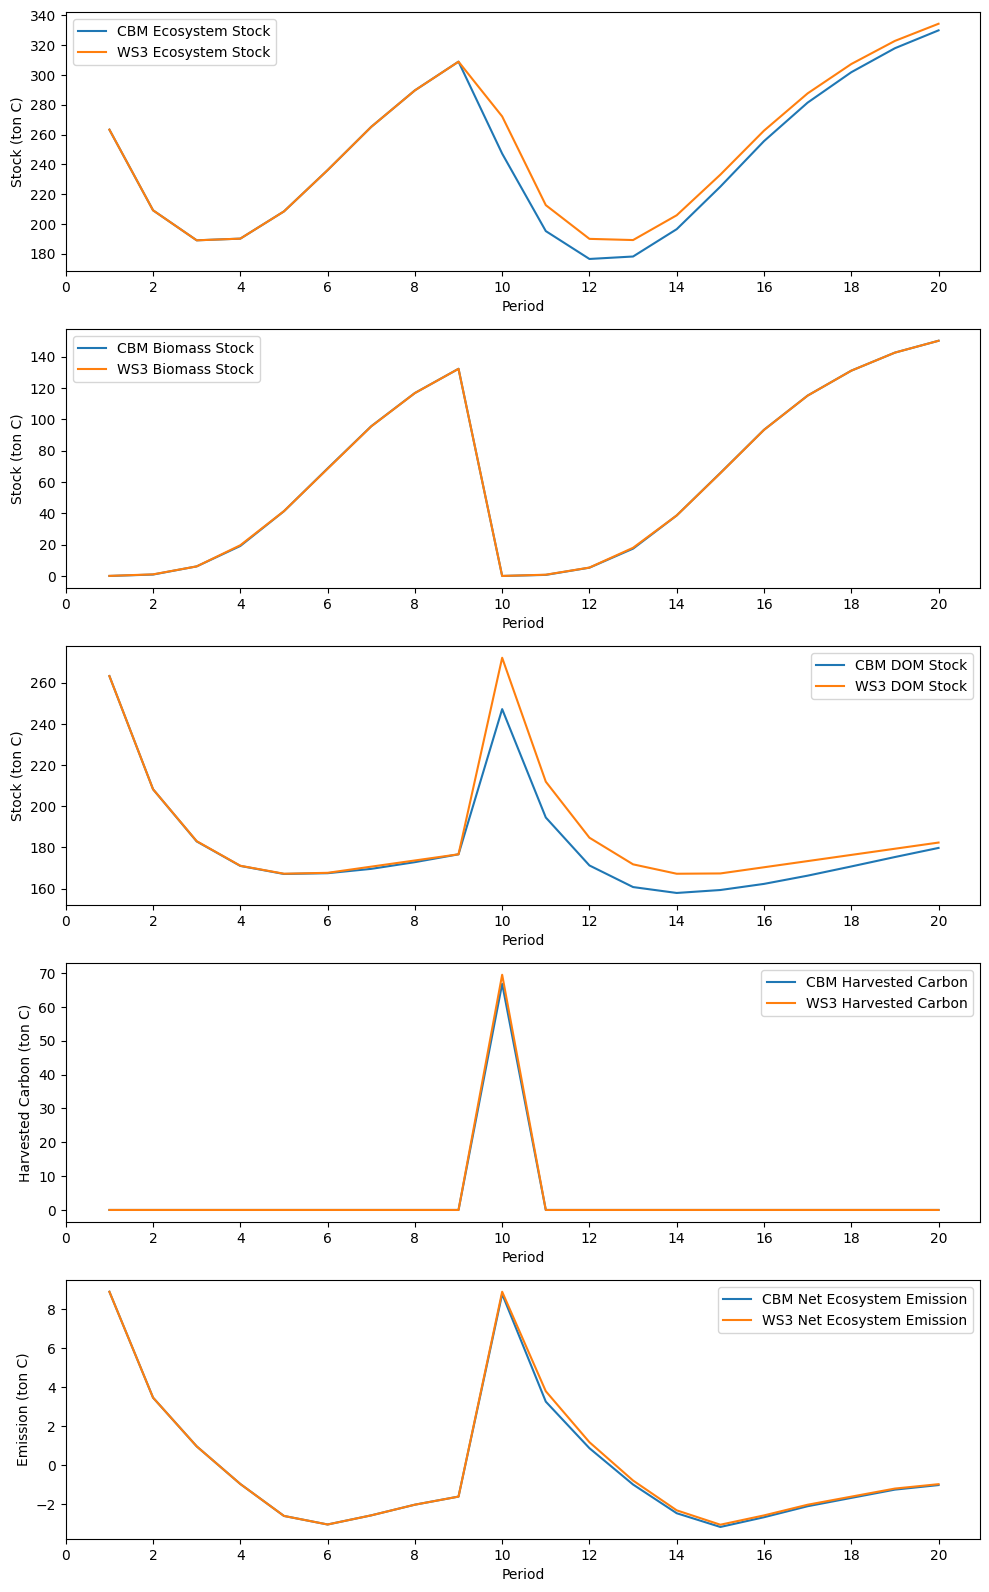

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5      41.345599  167.115383  208.460982        2.391898   
 5        6      68.654270  167.492616  236.146886        2.803922   
 6        7      95.596323  169.604358  265.200682        3.147085   
 7        8     116.807124  172.860296  289.667420        3.441617   
 8        9     132.272815  176.673403  308.946218        3.688798   
 9       10       0.000327  247.233349  247.233676        8.775872   
 10      11       0.683776  194.558937  195.242713        3.508049   
 11      12       5.284915  171.255381  176.540296        2.065280   
 12      13      17.434760  160.753803  178.188562        1.864110   
 13      14      38.

In [54]:
compare_ws3_cbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

### Clearcut two times

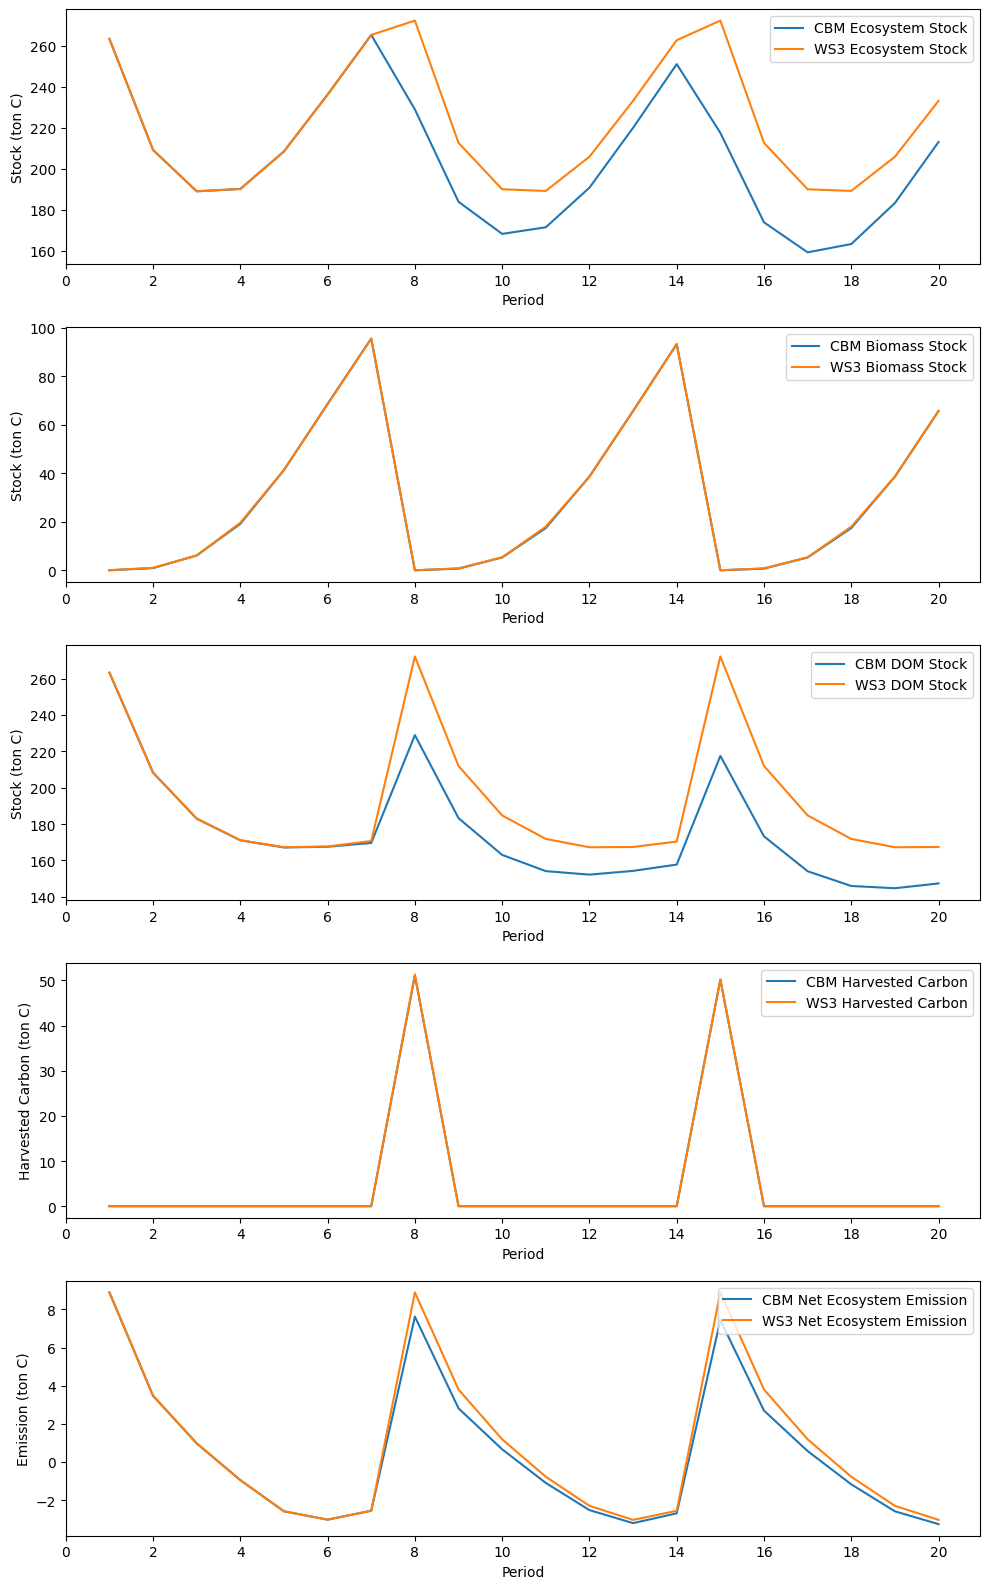

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5      41.345599  167.115383  208.460982        2.391898   
 5        6      68.654270  167.492616  236.146886        2.803922   
 6        7      95.596323  169.604358  265.200682        3.147085   
 7        8       0.000327  228.933427  228.933754        7.622965   
 8        9       0.683776  183.255390  183.939166        3.053896   
 9       10       5.284915  163.011213  168.296128        1.847400   
 10      11      17.434760  154.089764  171.524524        1.743172   
 11      12      38.643272  152.164984  190.808256        2.123821   
 12      13      65.745660  154.230904  219.976564        2.597499   
 13      14      93.

In [68]:
compare_ws3_cbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

### Clearcut three times

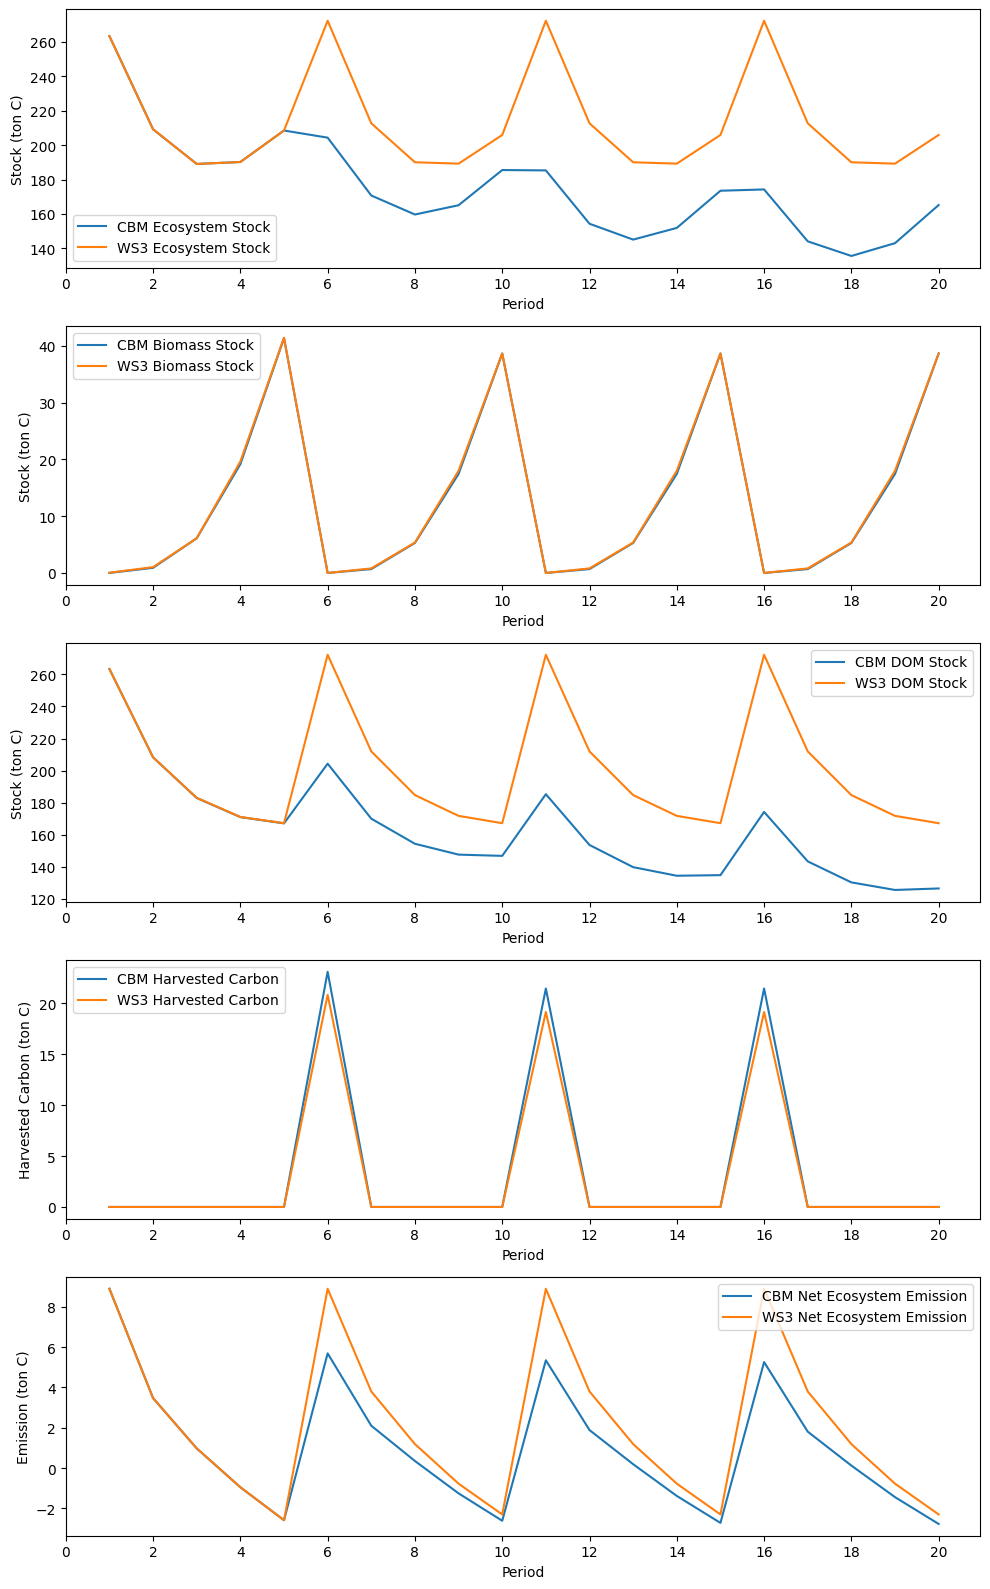

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5      41.345599  167.115383  208.460982        2.391898   
 5        6       0.000327  204.322781  204.323108        5.688258   
 6        7       0.683776  170.041839  170.725615        2.341112   
 7        8       5.284915  154.408878  159.693793        1.533796   
 8        9      17.434760  147.648241  165.083000        1.586560   
 9       10      38.643272  146.871783  185.515055        2.035134   
 10      11       0.000327  185.302818  185.303145        5.345544   
 11      12       0.683776  153.649664  154.333440        2.125262   
 12      13       5.284915  139.835880  145.120795        1.374207   
 13      14      17.

In [81]:
compare_ws3_cbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')

### Clearcut four times

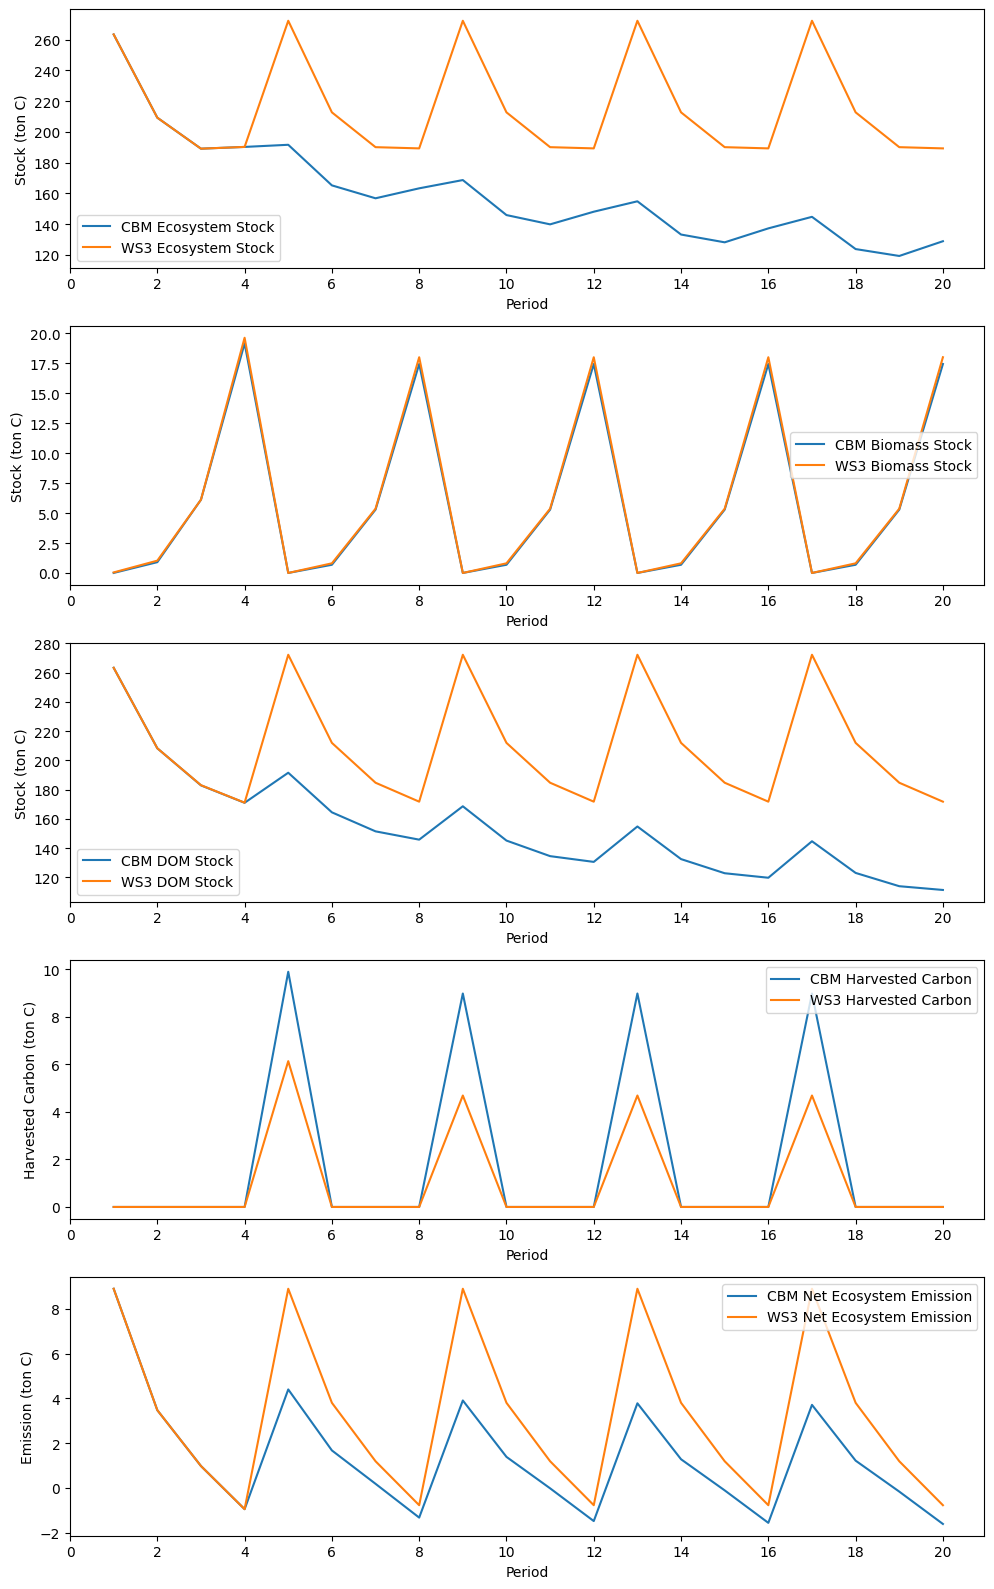

(    period  biomass_stock   dom_stock   eco_stock  total_emission  \
 0        1       0.002983  263.297469  263.300452        8.895193   
 1        2       0.901748  208.283756  209.185505        3.770192   
 2        3       6.110762  182.938737  189.049499        2.297960   
 3        4      19.154149  171.030874  190.185023        2.078214   
 4        5       0.000327  191.574854  191.575181        4.395538   
 5        6       0.683776  164.503884  165.187660        1.913622   
 6        7       5.284915  151.507205  156.792120        1.364508   
 7        8      17.434760  145.835426  163.270186        1.513885   
 8        9       0.000327  168.645898  168.646225        3.902991   
 9       10       0.683776  145.204622  145.888398        1.625478   
 10      11       5.284915  134.565345  139.850260        1.162601   
 11      12      17.434760  130.637355  148.072115        1.358328   
 12      13       0.000327  154.834772  154.835099        3.776325   
 13      14       0.

In [87]:
compare_ws3_cbm(fm, cbm_output_harvest, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')